## Importing the required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Grayscale
from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2335273961.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Loading and Preprocessing Image

torch.Size([300, 300, 3])

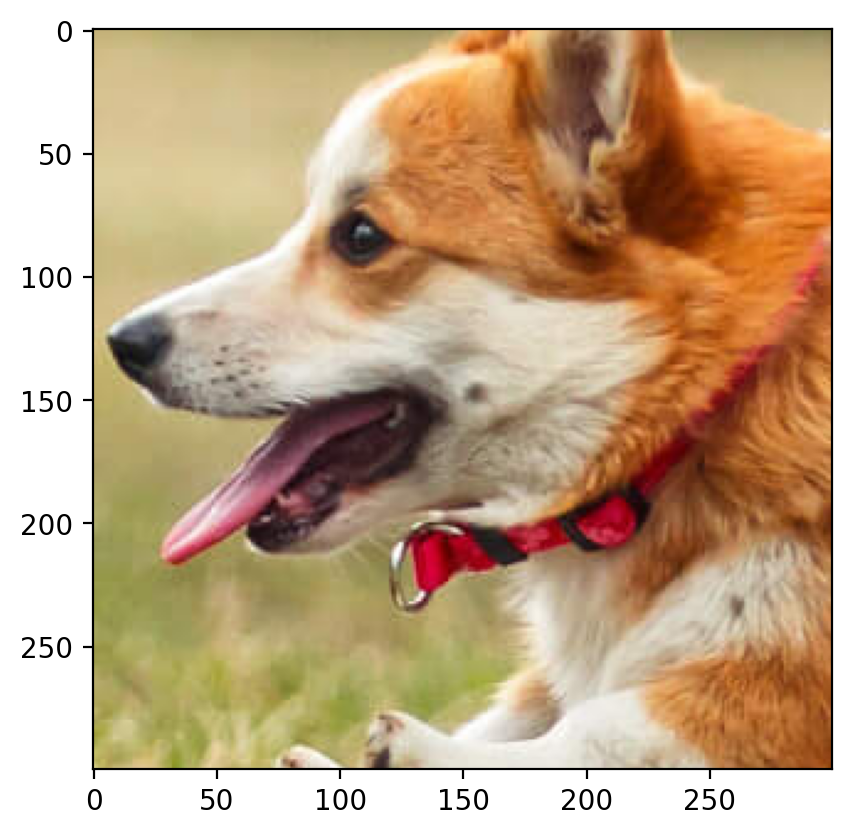

In [2]:
original_image = torchvision.io.read_image('dog.jpg')
cropped_image = torchvision.transforms.functional.crop(original_image,600,800,300,300)
cropped_image = rearrange(cropped_image,'c h w -> h w c')
plt.imshow(cropped_image)
cropped_image.shape

### Creating 3 patches with one color, two colors and multiple colors

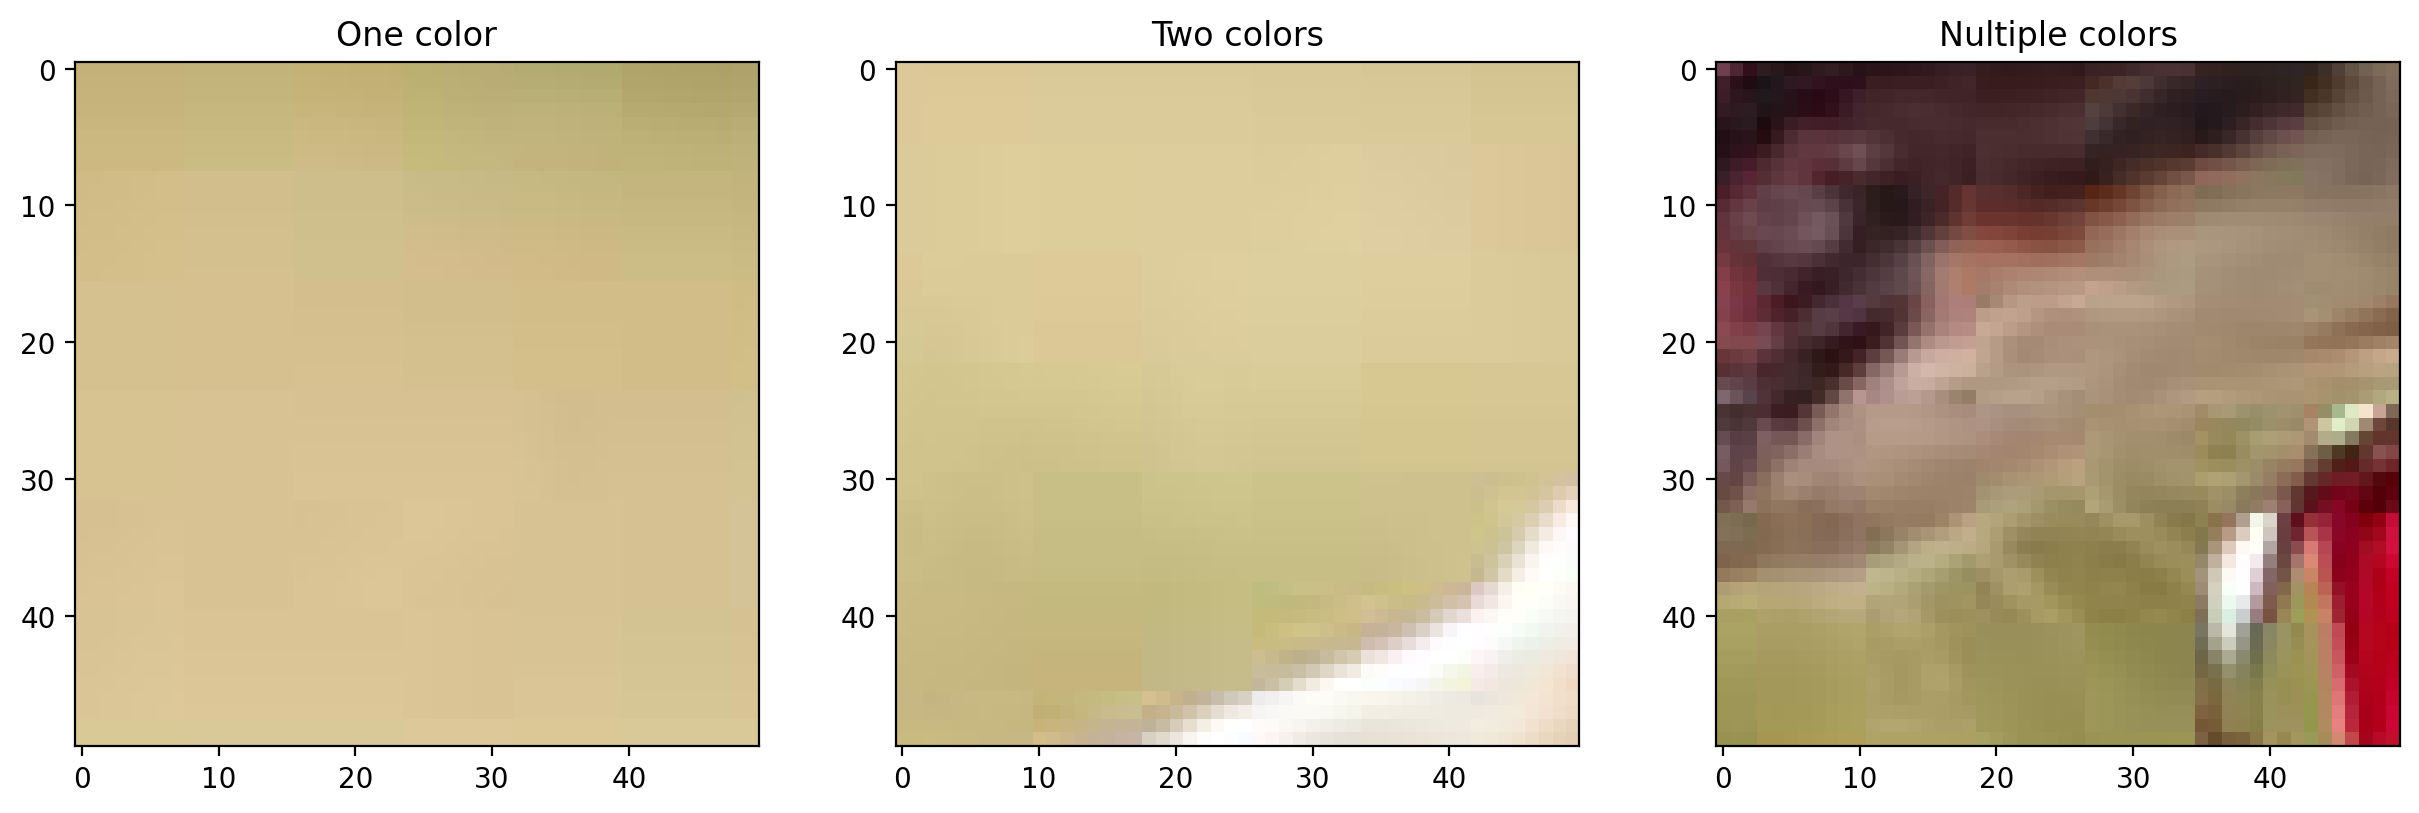

In [3]:
patch_1 = cropped_image[:50, :50]
patch_2 = cropped_image[50:100,30:80]
patch_3 = cropped_image[175:225,85:135]
ax, fig = plt.subplots(1,3, figsize=(15,15))
fig[0].imshow(patch_1)
fig[0].set_title('One color') 
fig[1].imshow(patch_2)
fig[1].set_title('Two colors')
fig[2].imshow(patch_3)
fig[2].set_title('Nultiple colors')
plt.show()


## Matrix Factorization

### Defining the metrics

In [54]:
def rmse(image1, image2):
    '''
    Function to return the root mean square error between two images
    Inputs:
    image1: First image
    image2: Second image

    Returns:
    rmse: Root mean square error between the two images
    '''
    image1 = image1.detach().cpu().numpy().astype(np.float64)
    image2 = image2.detach().cpu().numpy().astype(np.float64)
    return np.sqrt(np.mean((image1 - image2) ** 2))

def peak_snr(image1, image2):
    '''
    Function to return the peak signal to noise ratio between two images
    Inputs:
    image1: First image
    image2: Second image

    Returns:
    psnr: Peak signal to noise ratio between the two images
    '''
    image1 = image1.detach().cpu().numpy().astype(np.float64)
    image2 = image2.detach().cpu().numpy().astype(np.float64)
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr 


### Facorization Algorithm to Factorize image into two smaller rank matrices.

In [55]:
def factorize(A: torch.Tensor, k: int, epochs: int):
    '''
    Function to factorize an RGB image matrix A into two matrices W and H.
    The matrix A is of shape (m, n, 3) and the matrices W and H are of shape (m, k, 3) and (k, n, 3) respectively.

    Input:
    A: torch.Tensor: The matrix to be factorized (shape: m, n, 3)
    k: int: The rank of the factorization
    epochs: int: The number of epochs to train the model

    Returns:
    W: torch.Tensor: The matrix W of shape (m, k, 3)
    H: torch.Tensor: The matrix H of shape (k, n, 3)
    '''    
    m, n, c = A.shape  # Get dimensions of the input tensor
    W = torch.rand((m, k, c), requires_grad=True, device=device)
    H = torch.rand((k, n, c), requires_grad=True, device=device)
    A = A.to(device)
    
    optimizer = optim.Adam([W, H], lr=0.01)
    loss_arr = []
    print(f"Training for rank {k}")
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Compute A_hat for each channel separately
        A_hat = torch.zeros_like(A, device=device)
        for channel in range(c):
            A_hat[:, :, channel] = torch.matmul(W[:, :, channel], H[:, :, channel])
        
        loss = F.mse_loss(A_hat, A)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    print("--"*20)
    return W, H, loss_arr


### Function to Run the algorithm and Displaying Outputs for different ranks.

In [64]:
def get_data(patch_number:int, ranks: list, epochs: int, plot=True):
    '''
    Function to get the factorized matrices for different ranks

    Inputs:
    ranks: list: List of ranks to factorize the image into
    epochs: int: Number of epochs to train the model

    Returns:
    Ws: list: List of matrices W for each rank
    Hs: list: List of matrices H for each rank
    losses: list: List of loss arrays for each rank
    '''
    patch_mapping = {1: patch_1, 2: patch_2, 3: patch_3}
    Ws, Hs, losses = [], [], []
    for rank in ranks:
        W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)
        Ws.append(W)
        Hs.append(H)
        losses.append(loss_arr)
    print(W,H, loss_arr)
    if (plot):
        x = np.arange(epochs)
        for i, rank in enumerate(ranks):
            plt.plot(x, losses[i], label=f'Rank {rank}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs Epochs')
        plt.show()
    RMSE = []
    PSNR = []
    for i in range(len(ranks)):
        factorized_params = [Ws[i], Hs[i]]
        print(Ws[i].shape, Hs[i].shape) 
        channel_1 = torch.matmul(factorized_params[0][:, :, 0], factorized_params[1][:, :, 0])
        channel_2 = torch.matmul(factorized_params[0][:, :, 1], factorized_params[1][:, :, 1])
        channel_3 = torch.matmul(factorized_params[0][:, :, 2], factorized_params[1][:, :, 2])
        reconstructed_image = torch.stack([channel_1, channel_2, channel_3])
        reconstructed_image = torch.clamp(reconstructed_image, 0, 255)
        RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
        PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
        copy = cropped_image.detach().clone().cpu().numpy()
        if patch_number==1:
            copy[:50, :50] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        elif patch_number==2:
            copy[50:100,30:80] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        else:
            copy[175:225,85:135] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        fig,ax = plt.subplots(1,4, figsize=(15,15))
        ax[0].imshow(patch_mapping[patch_number])
        ax[0].set_title('Original Patch')
        ax[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
        ax[1].set_title(f'Reconstructed Patch Rank = {ranks[i]}')
        ax[2].imshow(cropped_image)
        ax[2].set_title('Original Image')
        ax[3].imshow(copy)
        ax[3].set_title(f'Reconstructed Image Rank = {ranks[i]}')
        plt.show()
    return Ws, Hs, losses, RMSE, PSNR

## Patch 1 - Single Colored Patch

C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)


Training for rank 5
Epoch 1/1000, Loss: 33070.29296875
Epoch 101/1000, Loss: 28617.365234375
Epoch 201/1000, Loss: 18647.34765625
Epoch 301/1000, Loss: 8189.001953125
Epoch 401/1000, Loss: 2195.173095703125
Epoch 501/1000, Loss: 346.6812438964844
Epoch 601/1000, Loss: 40.69736099243164
Epoch 701/1000, Loss: 8.769033432006836
Epoch 801/1000, Loss: 5.562590599060059
Epoch 901/1000, Loss: 5.123169898986816
----------------------------------------
Training for rank 10
Epoch 1/1000, Loss: 32609.845703125
Epoch 101/1000, Loss: 24179.26953125
Epoch 201/1000, Loss: 9480.9580078125
Epoch 301/1000, Loss: 1398.7408447265625
Epoch 401/1000, Loss: 75.34974670410156
Epoch 501/1000, Loss: 8.024224281311035
Epoch 601/1000, Loss: 5.290004253387451
Epoch 701/1000, Loss: 5.089089870452881
Epoch 801/1000, Loss: 5.072455883026123
Epoch 901/1000, Loss: 5.069003582000732
----------------------------------------
Training for rank 25
Epoch 1/1000, Loss: 31304.55859375
Epoch 101/1000, Loss: 13849.7099609375
Epo

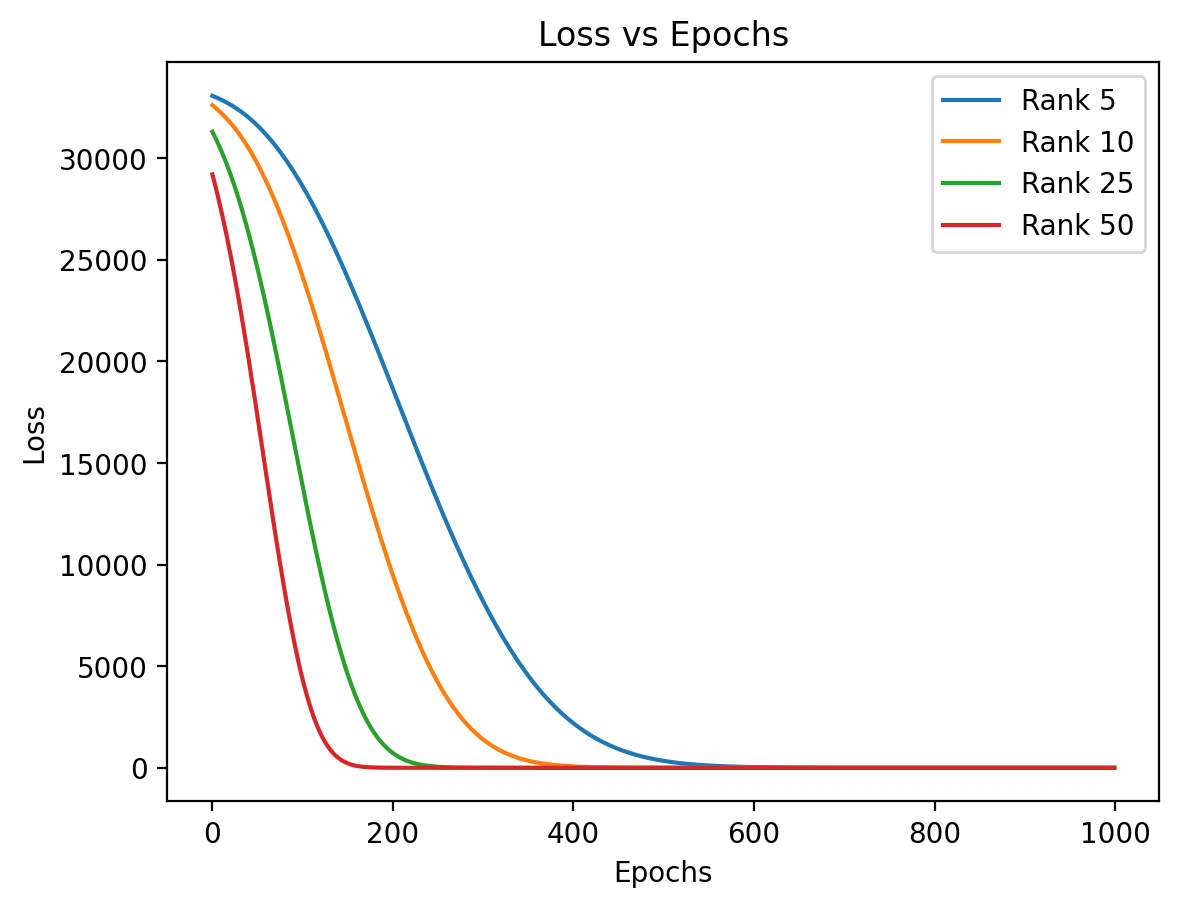

torch.Size([50, 5, 3]) torch.Size([5, 50, 3])


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))


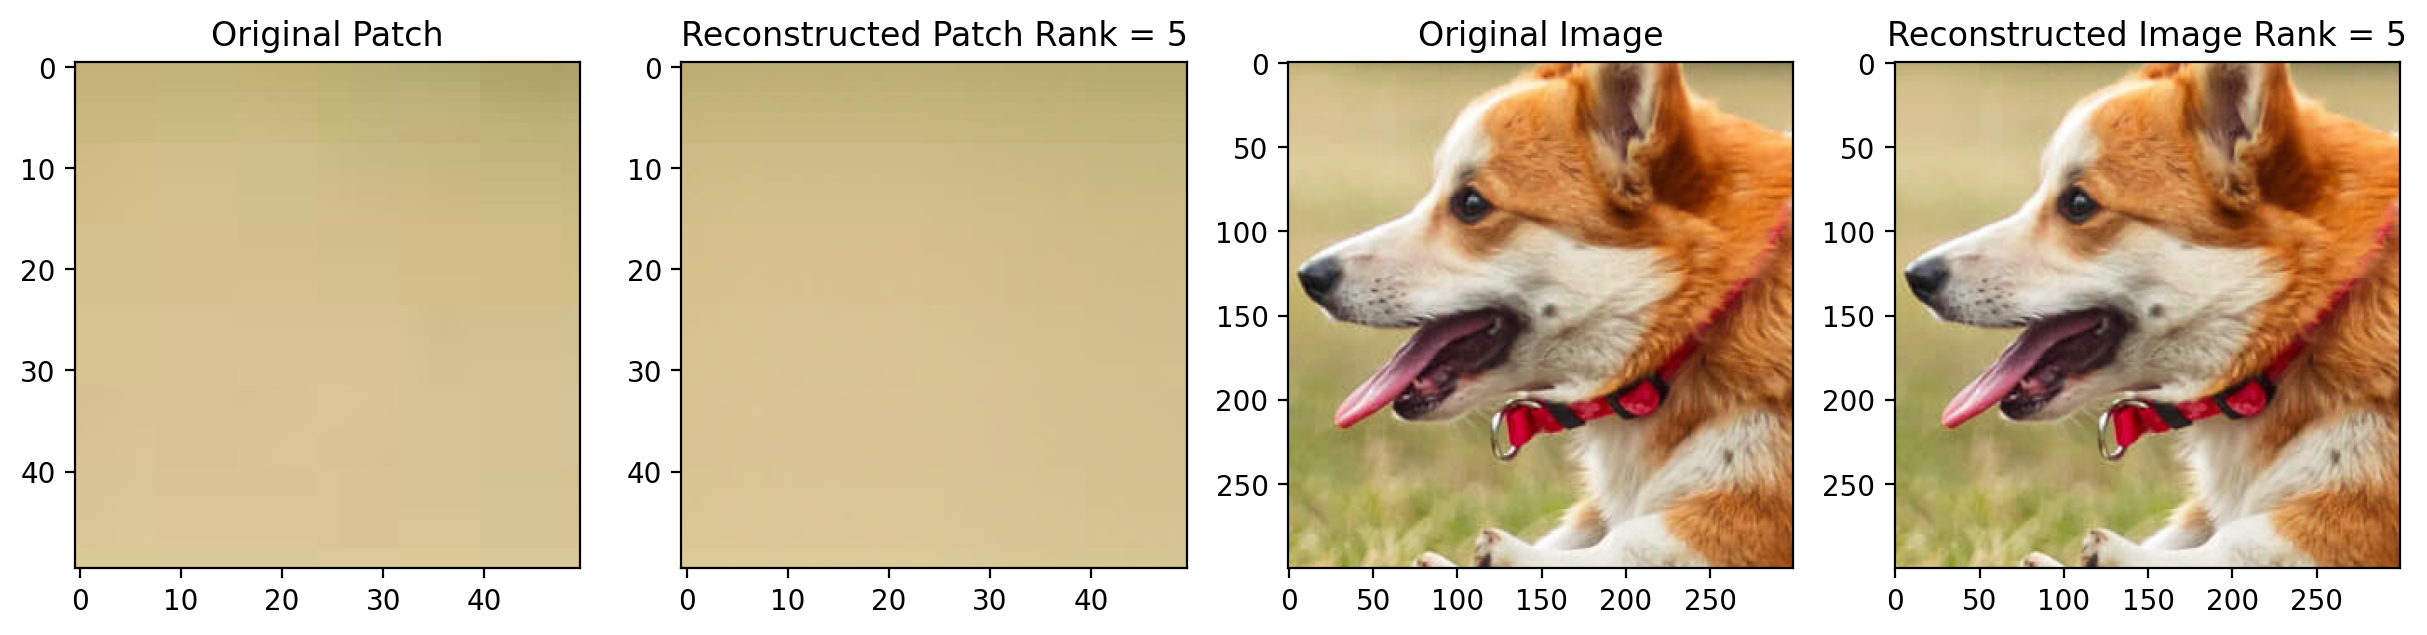

torch.Size([50, 10, 3]) torch.Size([10, 50, 3])


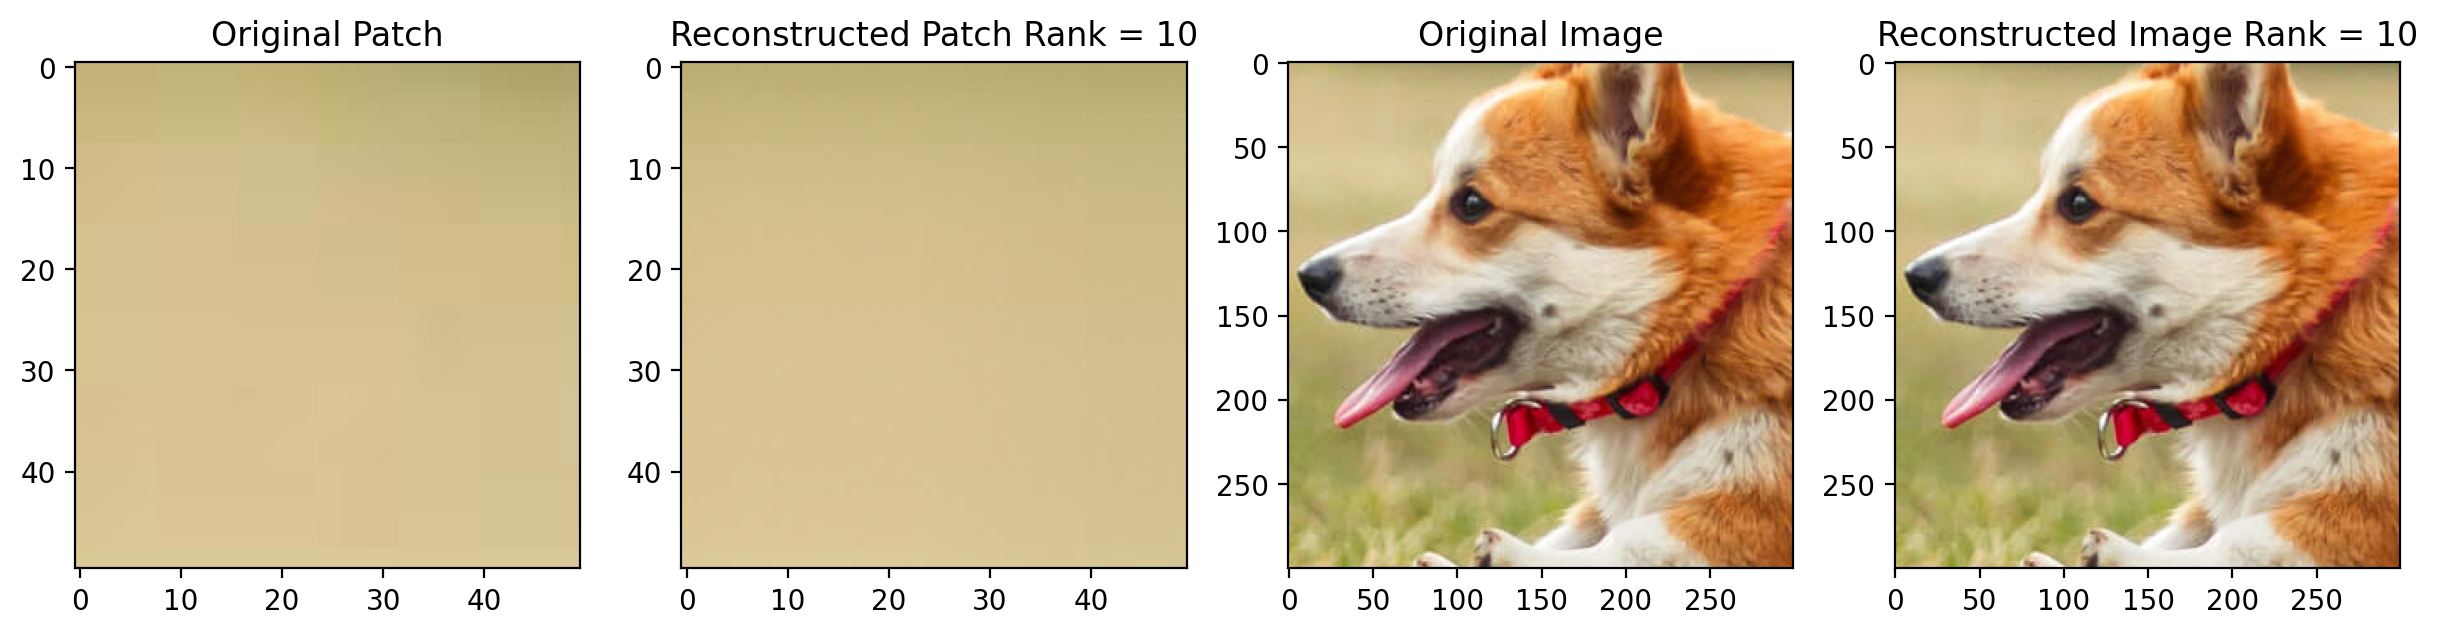

torch.Size([50, 25, 3]) torch.Size([25, 50, 3])


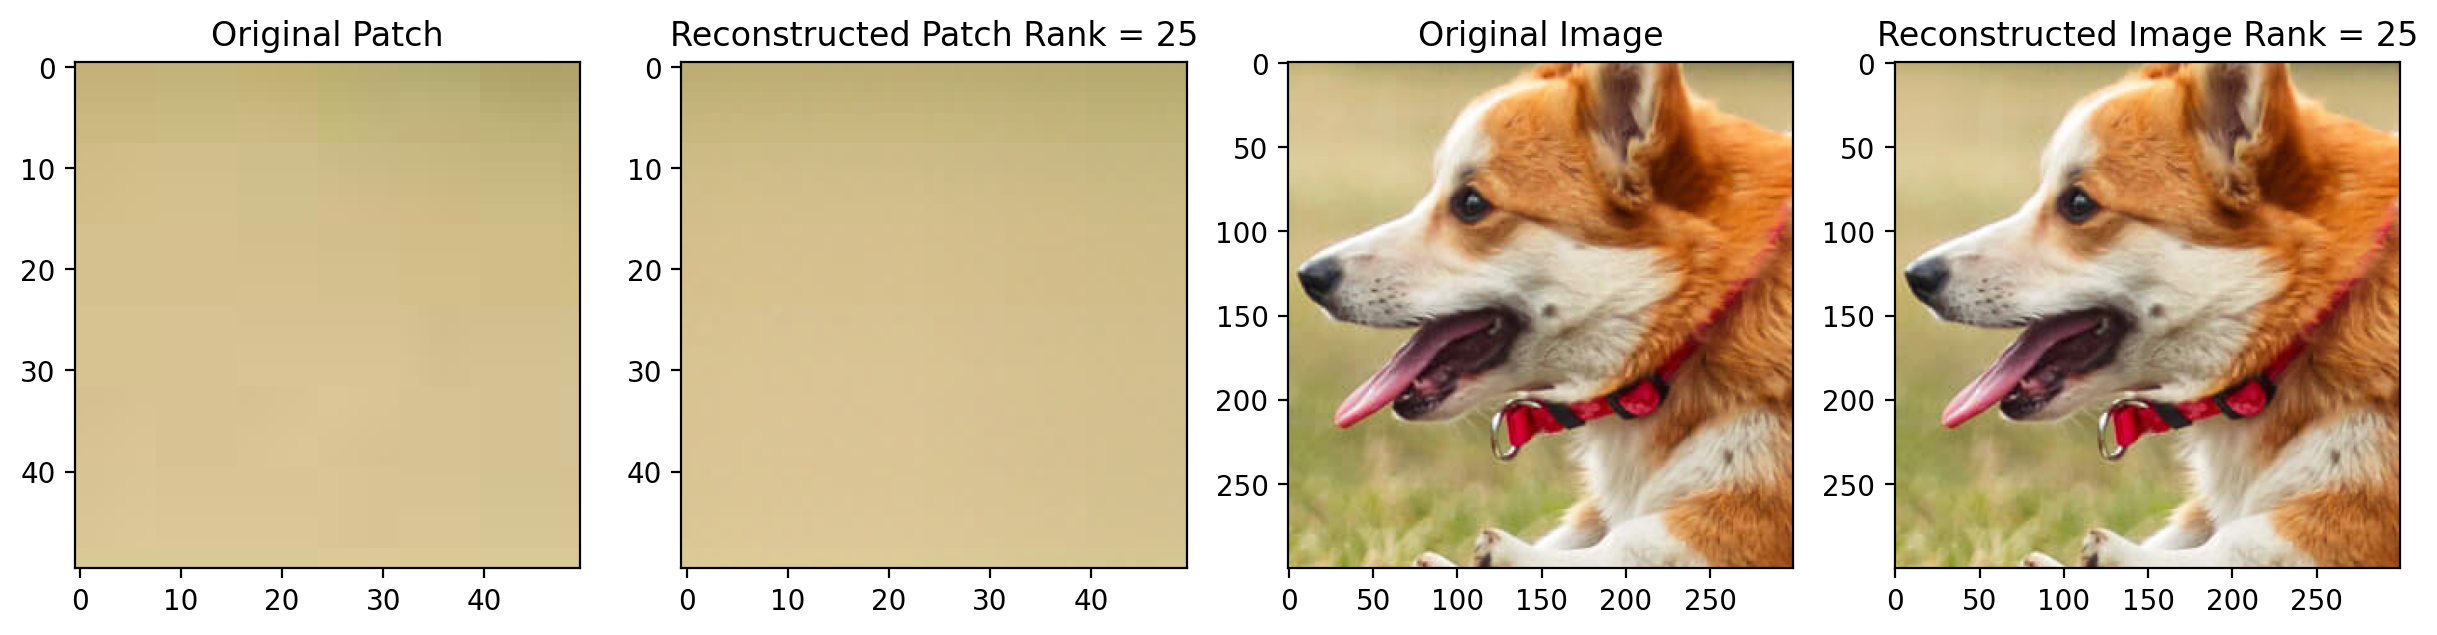

torch.Size([50, 50, 3]) torch.Size([50, 50, 3])


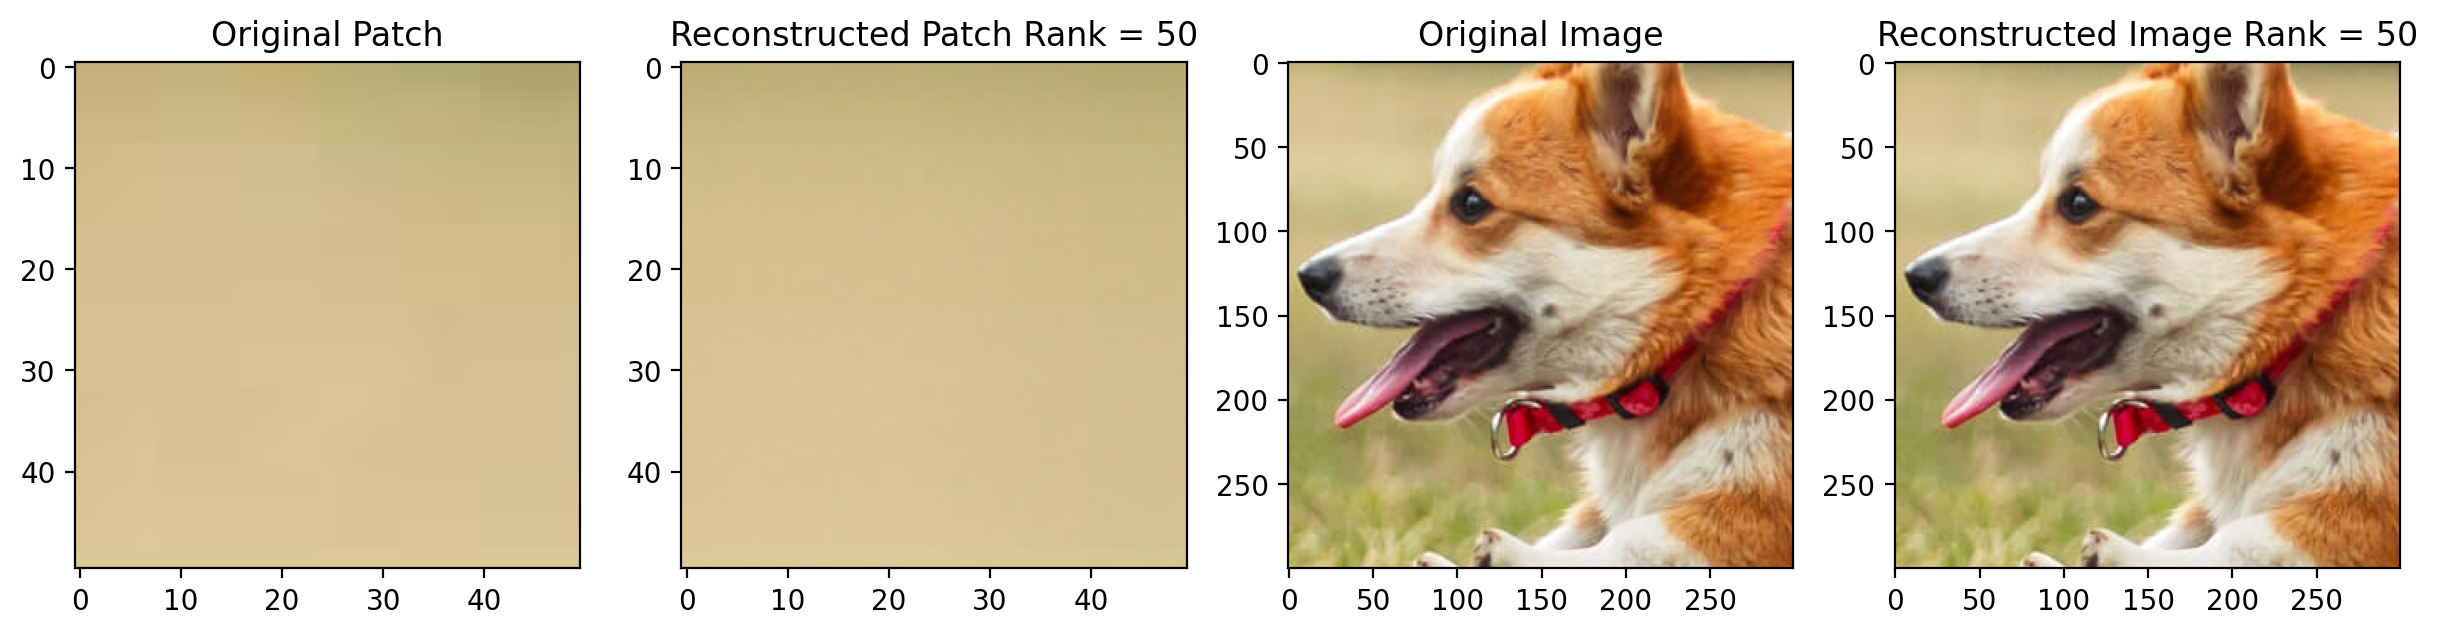

In [65]:
ranks = [5,10,25,50]
params_patch_1 = get_data(1, [5,10,25,50], 1000)

In [66]:
RMSE, PSNR = params_patch_1[3], params_patch_1[4]
for i in range(len(ranks)):
    print(f'Rank: {ranks[i]}, RMSE: {RMSE[i]}, PSNR: {PSNR[i]}')

Rank: 5, RMSE: 2.247920902291342, PSNR: 41.09518309620804
Rank: 10, RMSE: 2.2507991016329143, PSNR: 41.08406894586021
Rank: 25, RMSE: 2.237478042195246, PSNR: 41.135627968698714
Rank: 50, RMSE: 2.2370244554655034, PSNR: 41.13738897086215


## Patch 2 - Two Colored Patch

Training for rank 5
Epoch 1/2000, Loss: 36726.109375
Epoch 101/2000, Loss: 32018.3359375


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)


Epoch 201/2000, Loss: 21364.12109375
Epoch 301/2000, Loss: 9878.6943359375
Epoch 401/2000, Loss: 2977.15380859375
Epoch 501/2000, Loss: 706.6264038085938
Epoch 601/2000, Loss: 296.4154357910156
Epoch 701/2000, Loss: 247.17393493652344
Epoch 801/2000, Loss: 240.86740112304688
Epoch 901/2000, Loss: 239.72341918945312
Epoch 1001/2000, Loss: 239.47157287597656
Epoch 1101/2000, Loss: 239.38926696777344
Epoch 1201/2000, Loss: 239.32859802246094
Epoch 1301/2000, Loss: 239.25888061523438
Epoch 1401/2000, Loss: 239.17039489746094
Epoch 1501/2000, Loss: 239.0547637939453
Epoch 1601/2000, Loss: 238.90032958984375
Epoch 1701/2000, Loss: 238.68943786621094
Epoch 1801/2000, Loss: 238.39511108398438
Epoch 1901/2000, Loss: 237.97486877441406
----------------------------------------
Training for rank 10
Epoch 1/2000, Loss: 36285.3125
Epoch 101/2000, Loss: 27402.51953125
Epoch 201/2000, Loss: 11394.3212890625
Epoch 301/2000, Loss: 2028.62744140625
Epoch 401/2000, Loss: 344.5667419433594
Epoch 501/2000, 

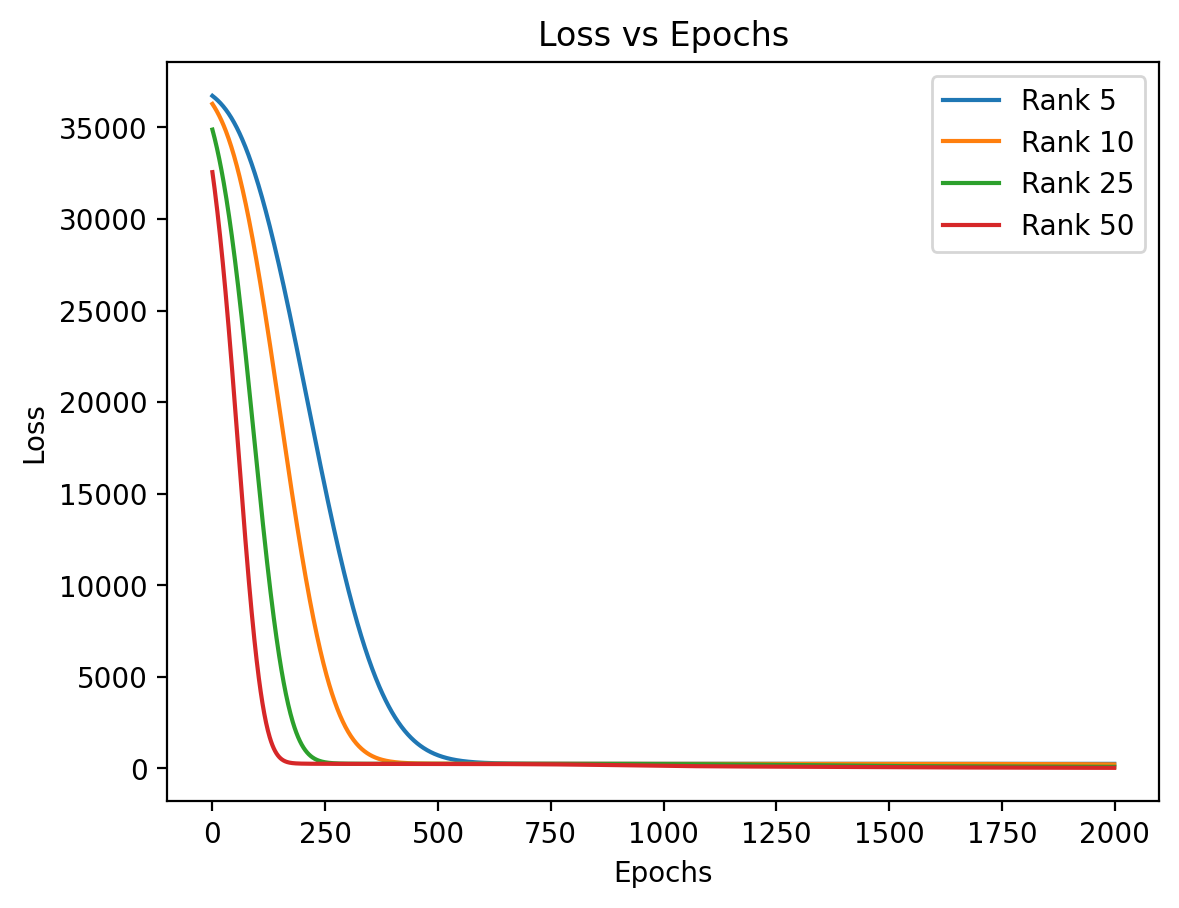

torch.Size([50, 5, 3]) torch.Size([5, 50, 3])


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))


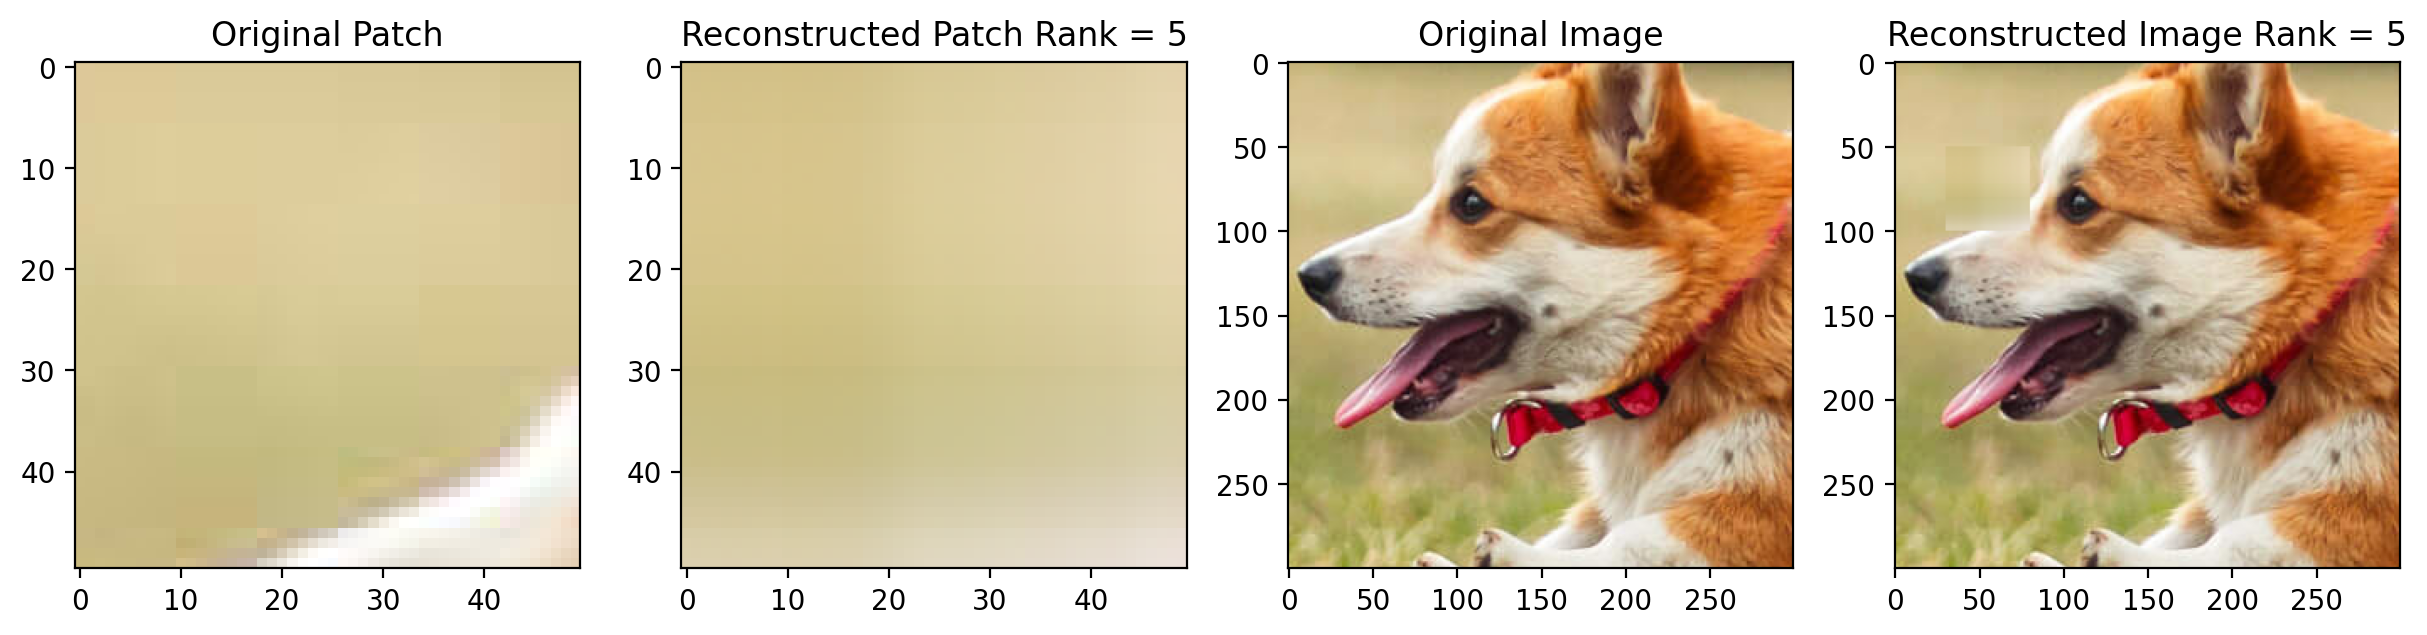

torch.Size([50, 10, 3]) torch.Size([10, 50, 3])


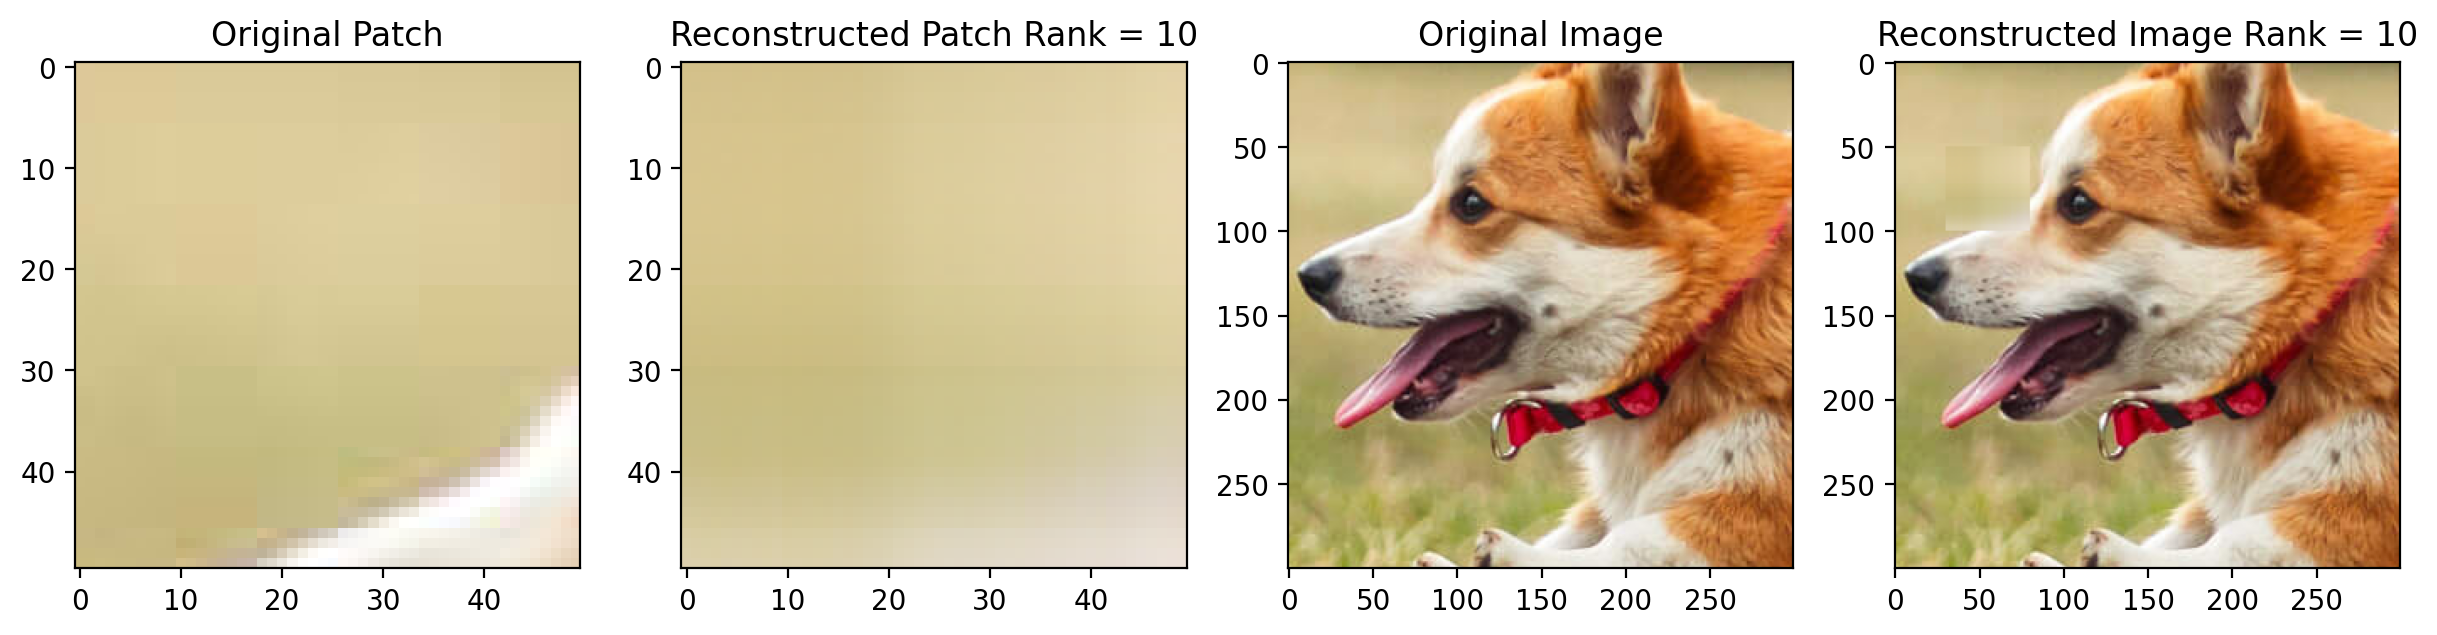

torch.Size([50, 25, 3]) torch.Size([25, 50, 3])


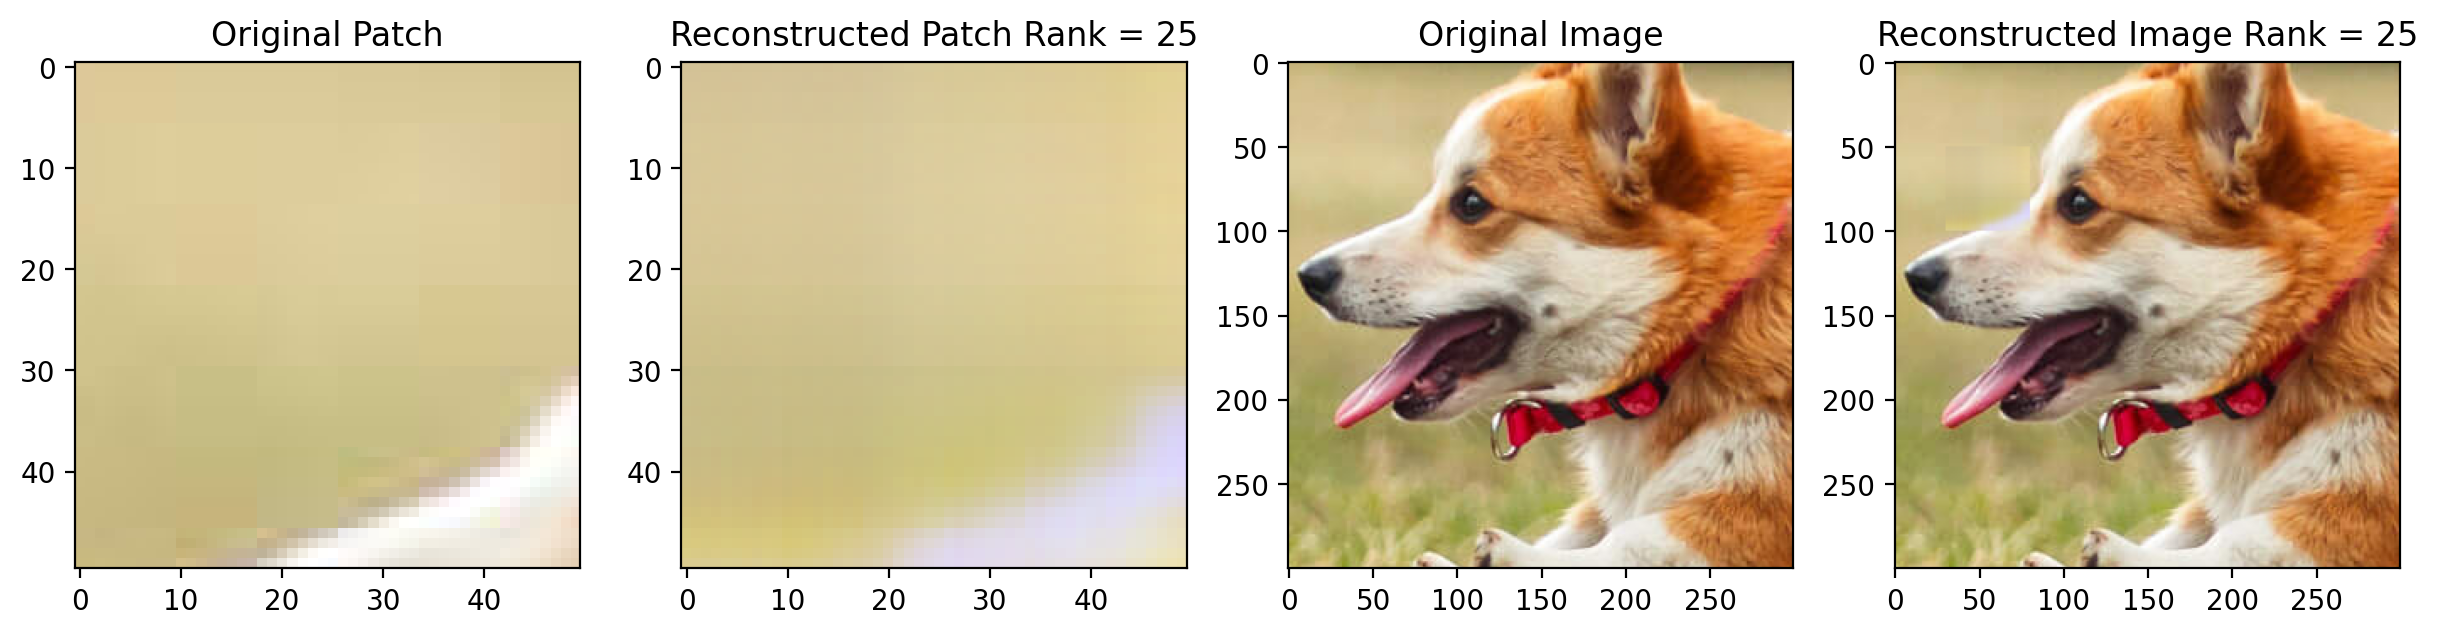

torch.Size([50, 50, 3]) torch.Size([50, 50, 3])


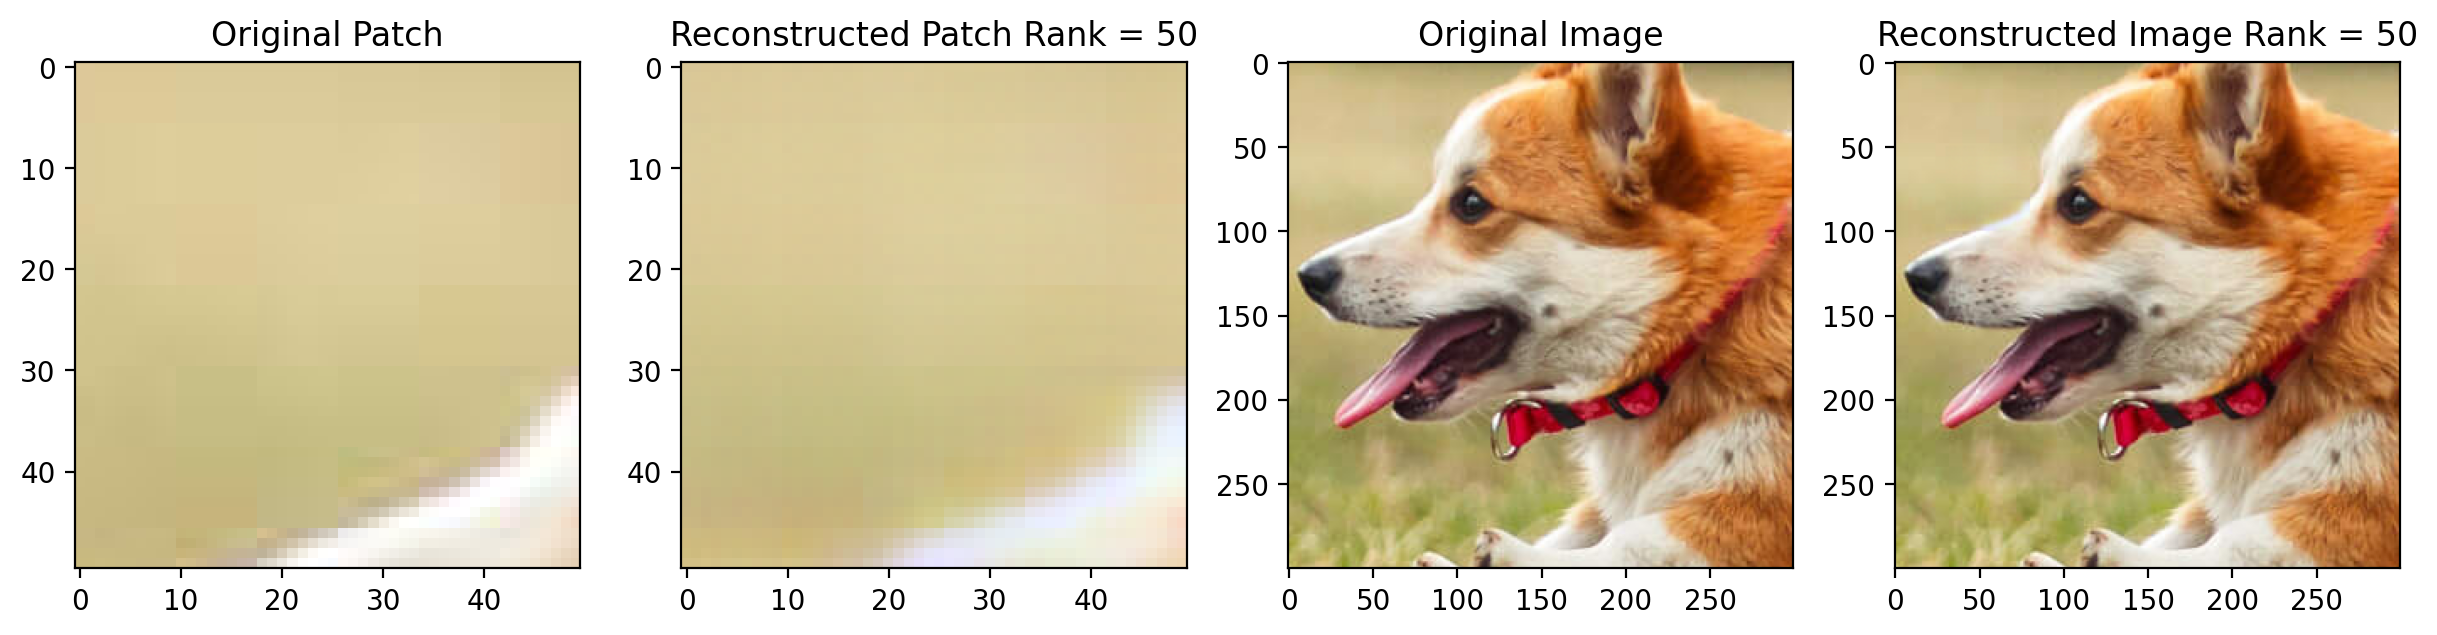

Rank: 5, RMSE: 15.406528359032308, PSNR: 24.37670785491243
Rank: 10, RMSE: 14.349490214268052, PSNR: 24.994074160189005
Rank: 25, RMSE: 8.63431885784965, PSNR: 29.40624195403775
Rank: 50, RMSE: 4.392520873566567, PSNR: 35.27652692927901


In [67]:
params_patch_2 = get_data(2, [5,10,25,50], 2000)   
RMSE, PSNR = params_patch_2[3], params_patch_2[4]
for i in range(len(ranks)):
    print(f'Rank: {ranks[i]}, RMSE: {RMSE[i]}, PSNR: {PSNR[i]}')

## Patch 3 - Multi Colored Patch

Training for rank 5
Epoch 1/2000, Loss: 14222.9560546875
Epoch 101/2000, Loss: 11576.6591796875
Epoch 201/2000, Loss: 6527.0400390625


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)


Epoch 301/2000, Loss: 2675.372802734375
Epoch 401/2000, Loss: 1232.51123046875
Epoch 501/2000, Loss: 931.4237060546875
Epoch 601/2000, Loss: 887.7454223632812
Epoch 701/2000, Loss: 881.0745849609375
Epoch 801/2000, Loss: 878.0479125976562
Epoch 901/2000, Loss: 872.5955810546875
Epoch 1001/2000, Loss: 859.9913330078125
Epoch 1101/2000, Loss: 833.53125
Epoch 1201/2000, Loss: 788.9773559570312
Epoch 1301/2000, Loss: 730.8347778320312
Epoch 1401/2000, Loss: 668.538818359375
Epoch 1501/2000, Loss: 611.3982543945312
Epoch 1601/2000, Loss: 566.7274780273438
Epoch 1701/2000, Loss: 533.9507446289062
Epoch 1801/2000, Loss: 507.22808837890625
Epoch 1901/2000, Loss: 481.64239501953125
----------------------------------------
Training for rank 10
Epoch 1/2000, Loss: 13967.703125
Epoch 101/2000, Loss: 9210.3134765625
Epoch 201/2000, Loss: 3052.09228515625
Epoch 301/2000, Loss: 1088.4366455078125
Epoch 401/2000, Loss: 892.6054077148438
Epoch 501/2000, Loss: 879.4144287109375
Epoch 601/2000, Loss: 873

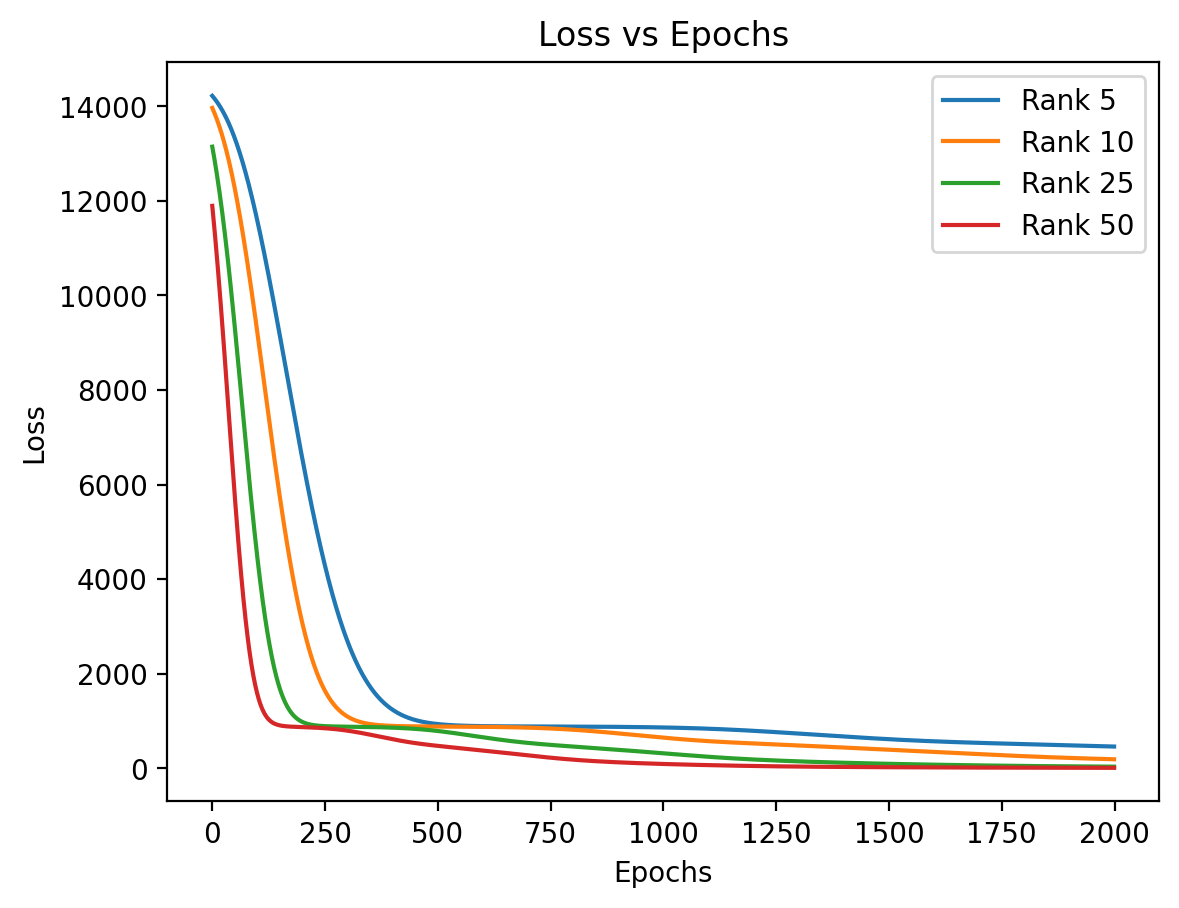

torch.Size([50, 5, 3]) torch.Size([5, 50, 3])


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_25728\2974699315.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))


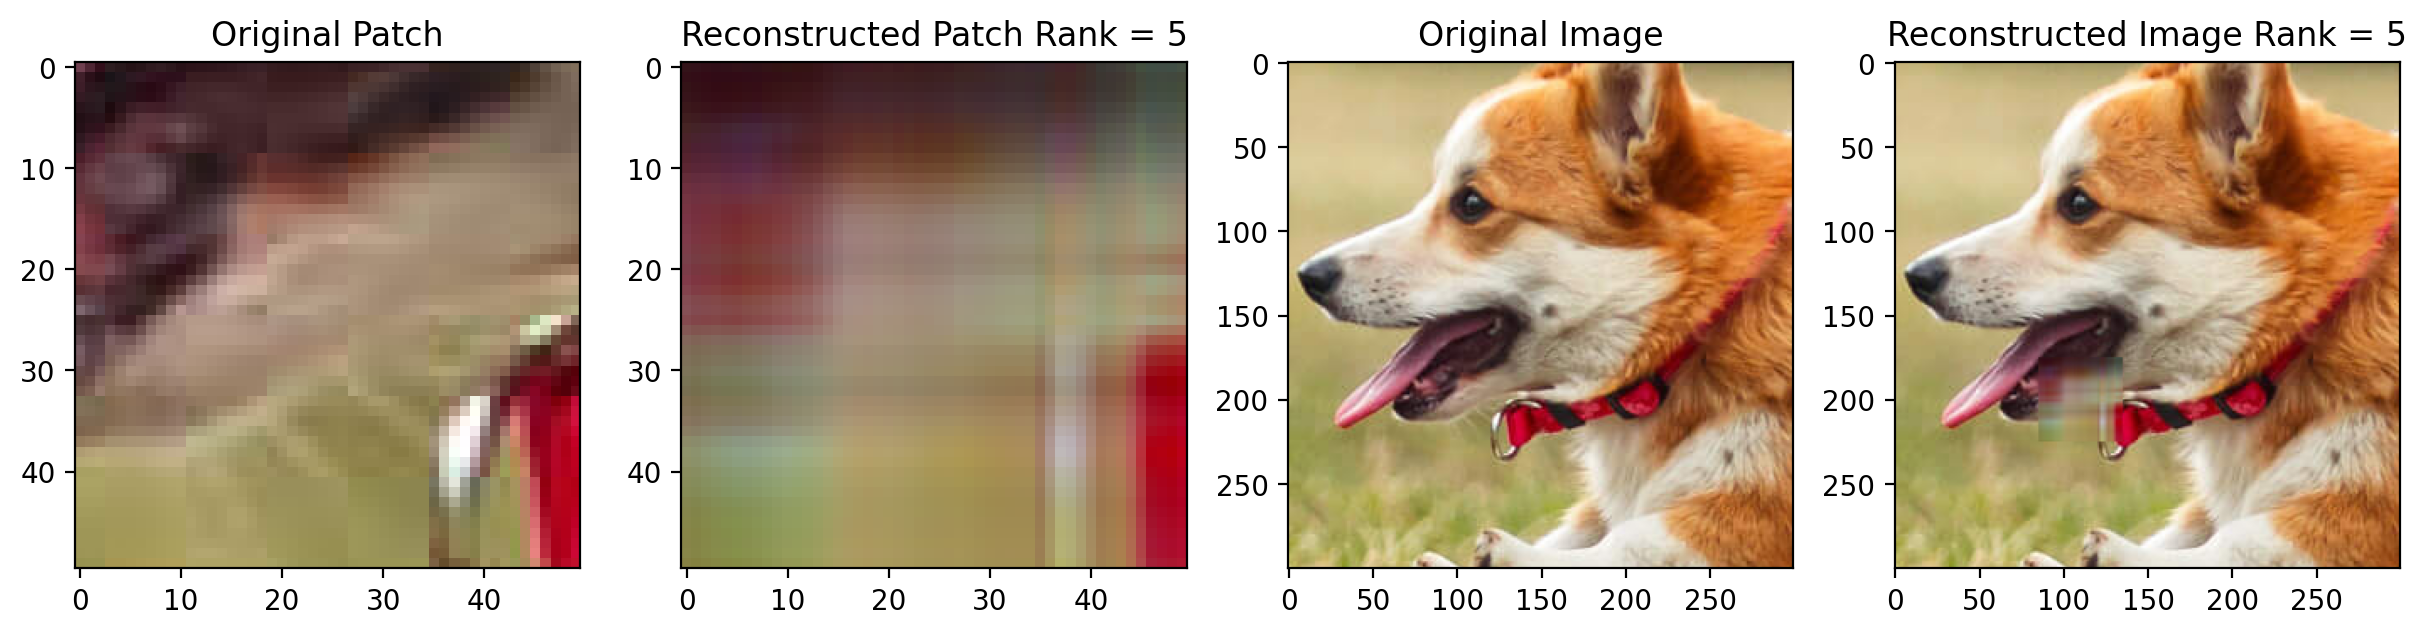

torch.Size([50, 10, 3]) torch.Size([10, 50, 3])


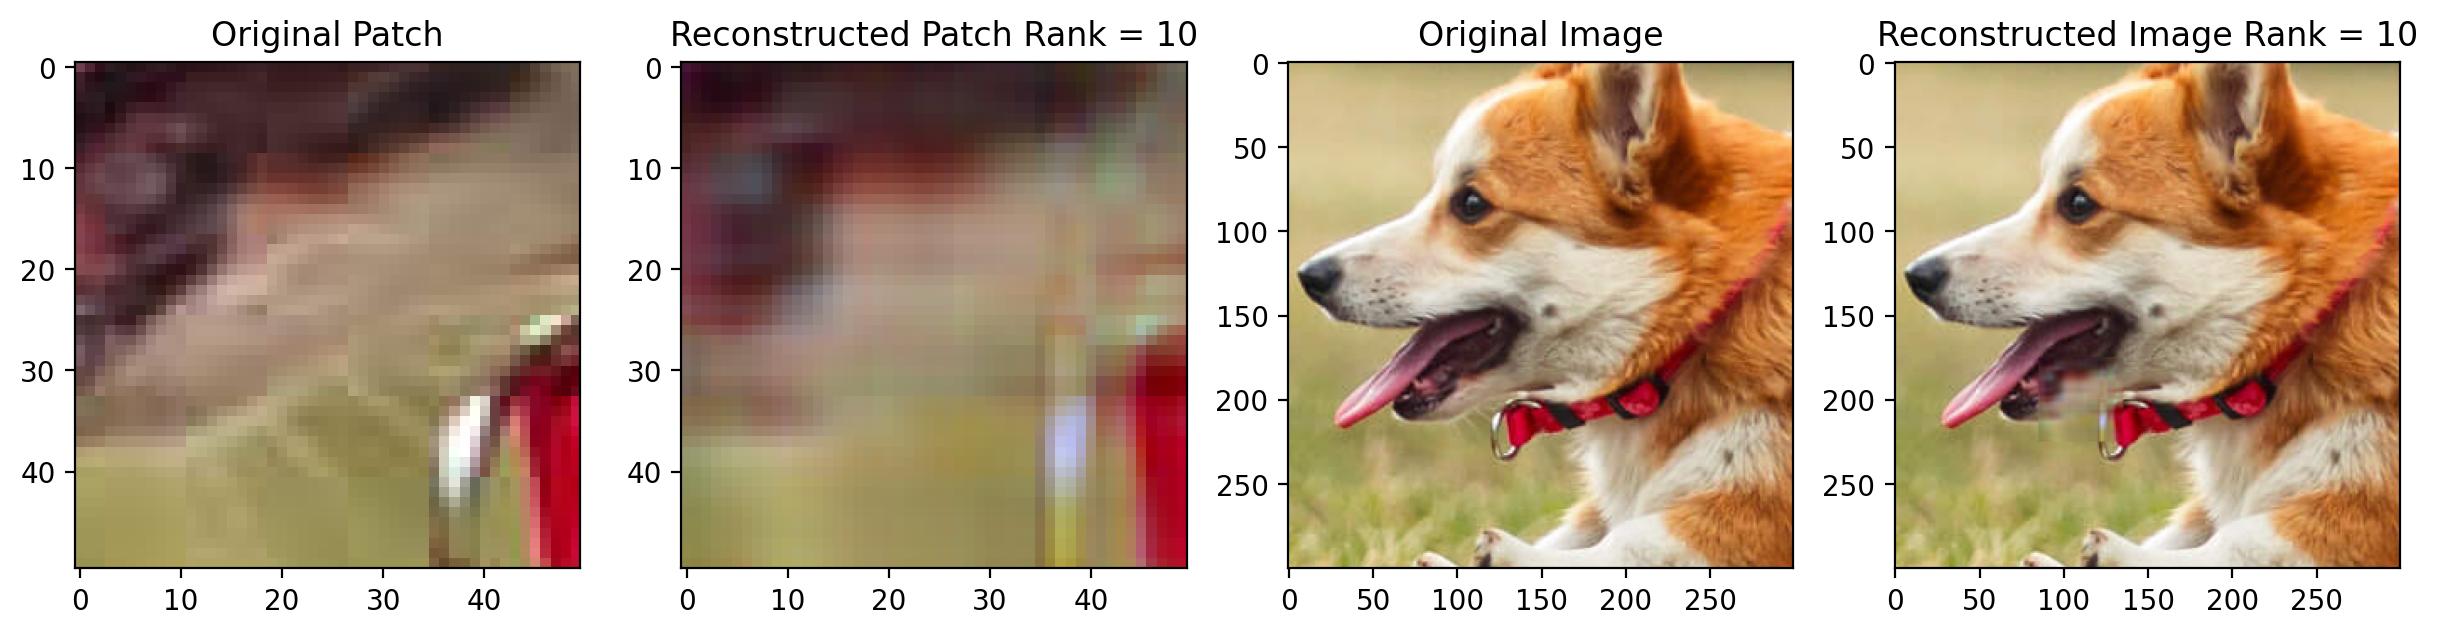

torch.Size([50, 25, 3]) torch.Size([25, 50, 3])


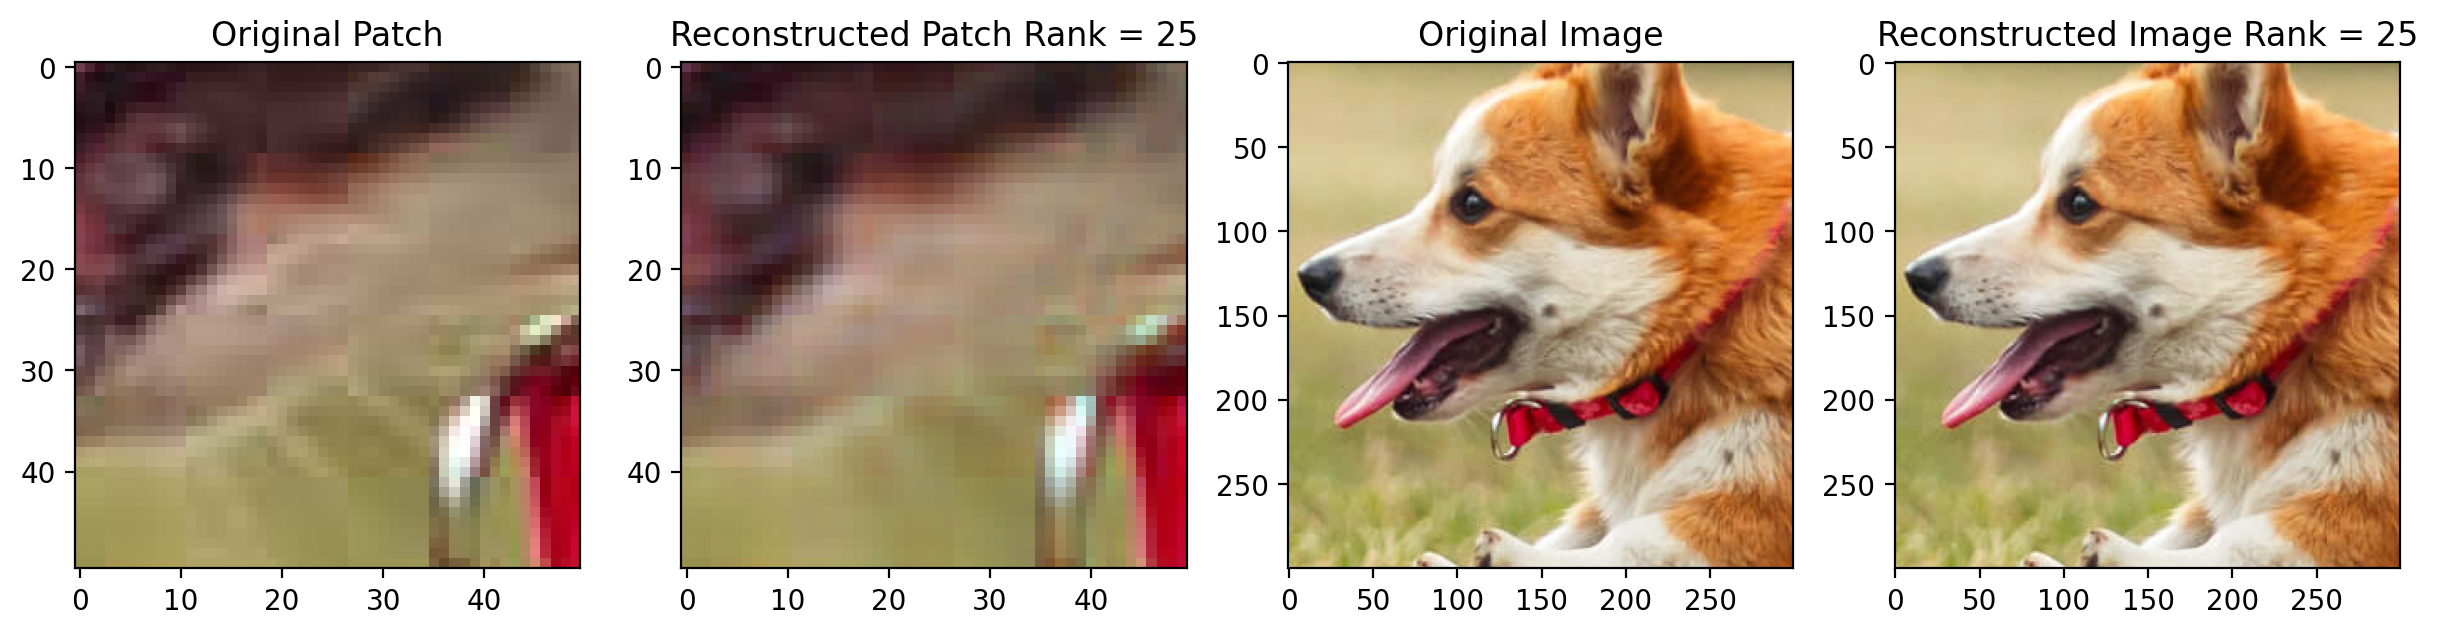

torch.Size([50, 50, 3]) torch.Size([50, 50, 3])


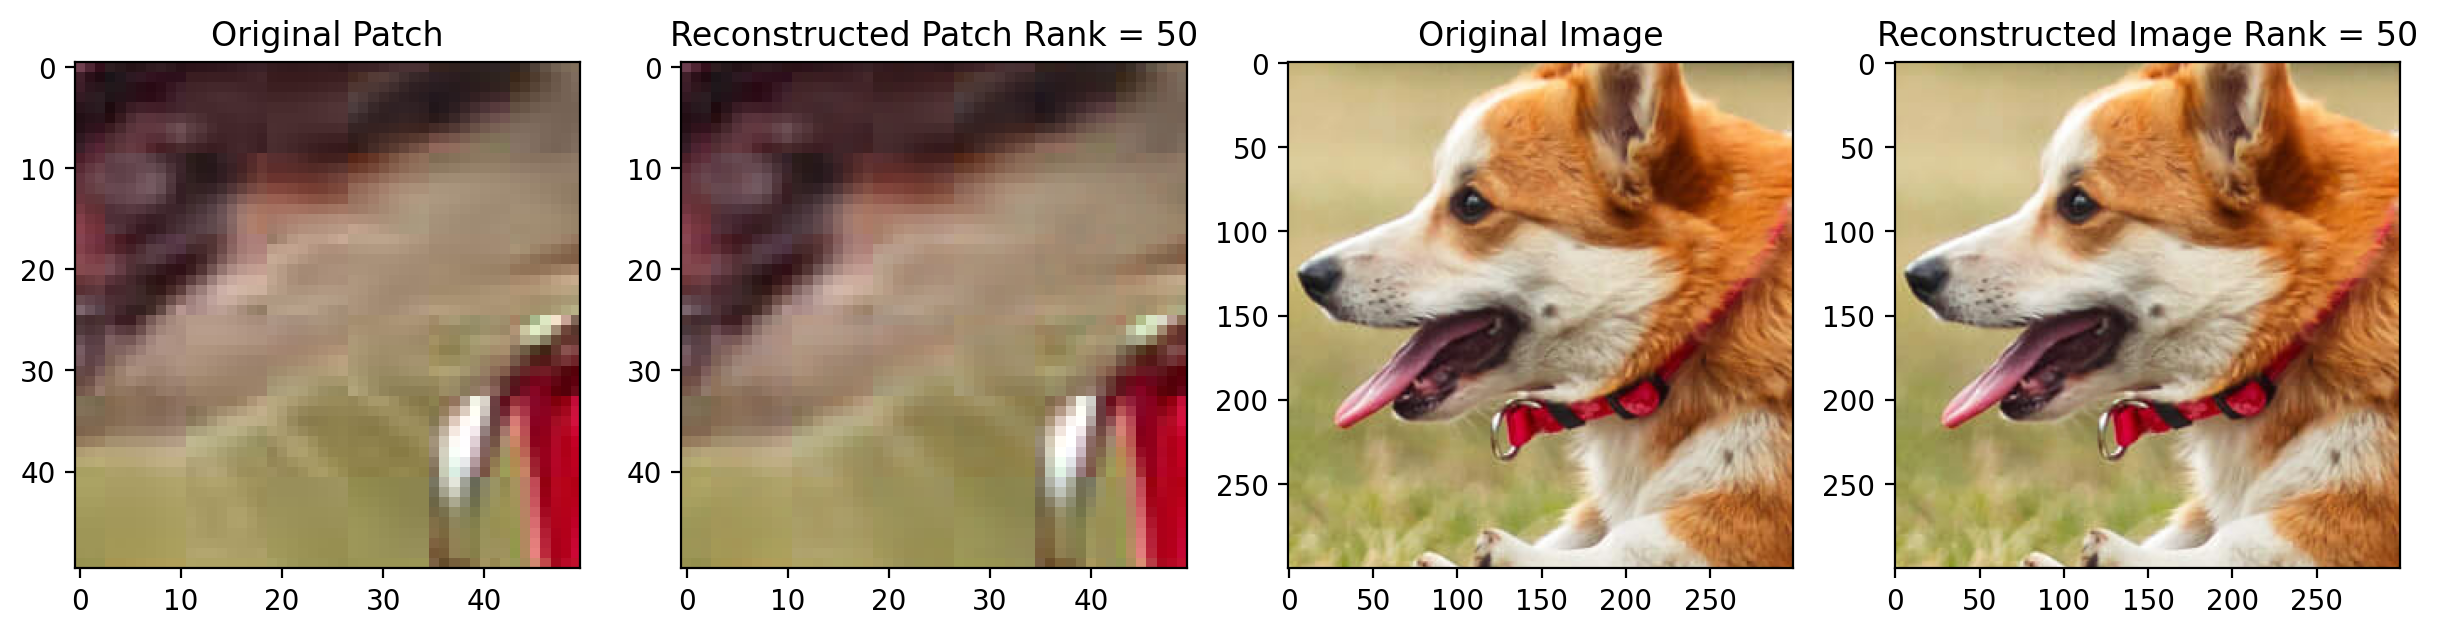

Rank: 5, RMSE: 21.3465451093789, PSNR: 21.54425169953525
Rank: 10, RMSE: 13.649353724322031, PSNR: 25.428561834777838
Rank: 25, RMSE: 5.531181936736265, PSNR: 33.2744447303061
Rank: 50, RMSE: 2.3483628487445105, PSNR: 40.71549958482787


In [68]:
params_patch_3 = get_data(3, [5,10,25,50], 2000)
RMSE, PSNR = params_patch_3[3], params_patch_3[4]
for i in range(len(ranks)):
    print(f'Rank: {ranks[i]}, RMSE: {RMSE[i]}, PSNR: {PSNR[i]}')

## Inferences:

1. The Patch reconstruction algorithm can efficiently reconstruct image with less variation in colors with relatively low rank factorization. 
2. The reconstruction for patch with high variation in color typically require high rank